# Advanced Physics Laboratory: analysis of beam profile with foil

## Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import sys
import subprocess

## Convert waveform files to numpy array and store

### Path to data

In [2]:
USER_PATH = "/home/rocco/University/APL/Lab/"
DATA_PATH = USER_PATH + "data/Au_3h_50k_-30_30"

### Unzip all data archives and get number of events

In [3]:
os.chdir(DATA_PATH)
for d in os.listdir("."):
    os.chdir(d)
    
    if not os.path.exists("data"):
        os.system("unzip data.zip -d data")
    os.chdir("../")

### Convert to numpy array

In [4]:
os.chdir(DATA_PATH)
for d in os.listdir("."):
    os.chdir(d)
    
    print("Storing in numpy array for:", d)
    if not os.path.exists(d+".npy"):
        N = len(os.listdir("./data"))
        M = 5000

        data = np.zeros((N,M),dtype=np.int16)
        for f,i in zip(os.listdir("./data"), range(N)):
            data[i,:] = np.loadtxt("./data/run_"+str(i)+"_segment_0.rpsd")
            if i%1000==0:
                sys.stdout.write('\r    Segment: '+str(i))
        print("\n")
        np.save(d+".npy", data)

    os.chdir("../")

Storing in numpy array for: 8_DX
Storing in numpy array for: 5_DX
Storing in numpy array for: 27_SX
    Segment: 0

Storing in numpy array for: 6_DX
Storing in numpy array for: 19_DX
Storing in numpy array for: 13_DX
Storing in numpy array for: 12_SX
    Segment: 19000

Storing in numpy array for: 1_DX
Storing in numpy array for: 18_DX
Storing in numpy array for: 5_SX
    Segment: 19000

Storing in numpy array for: 2_SX
    Segment: 49000

Storing in numpy array for: 8_SX
    Segment: 19000

Storing in numpy array for: 15_DX
Storing in numpy array for: 24_DX
    Segment: 0

Storing in numpy array for: 27_DX
    Segment: 0

Storing in numpy array for: 14_DX
Storing in numpy array for: 30_DX
    Segment: 0

Storing in numpy array for: 9_SX
    Segment: 19000

Storing in numpy array for: 11_SX
    Segment: 19000

Storing in numpy array for: 21_SX
    Segment: 0

Storing in numpy array for: 2_DX
Storing in numpy array for: 17_DX
Storing in numpy array for: 3_DX
Storing in numpy array for: 

## Load data

In [9]:
os.chdir(DATA_PATH)
os.chdir("0")

data = np.load("0.npy")
os.chdir(DATA_PATH)
data.shape

(50000, 5000)

## Analysis

### **[Example: 0]**

#### **[Example: 0]** Plot of waveforms

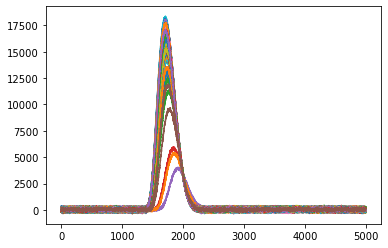

In [60]:
for i in range(data.shape[0]):
    plt.plot(data[i])
plt.show()

#### **[Example: 0]** Plot of integrals of waveforms

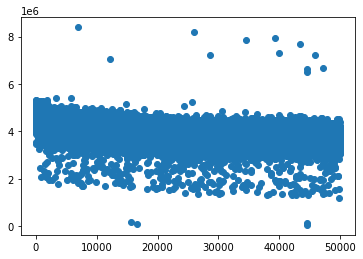

In [10]:
data_int = np.sum(data, axis=1)

plt.plot(data_int, "o")
plt.show()

#### **[Example: 0]** Plot of filtered integrals of waveforms

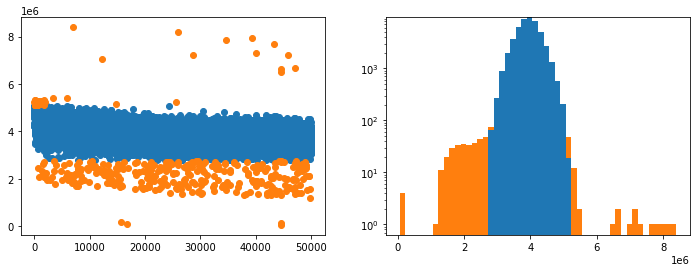

In [11]:
data_int_mean = np.mean(data_int)
data_int_var  = np.std(data_int)

mask_t = np.logical_and(data_int<data_int_mean+data_int_var*3, data_int>data_int_mean-data_int_var*3)
mask_f = np.logical_not(mask_t)

fig=plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(np.where(mask_t)[0], data_int[mask_t], "o")
plt.plot(np.where(mask_f)[0], data_int[mask_f], "o")

plt.subplot(1,2,2)
plt.hist([data_int[mask_t], data_int[mask_f]], bins=50, stacked=True)
plt.yscale("log")
plt.show()

### Now for every angle

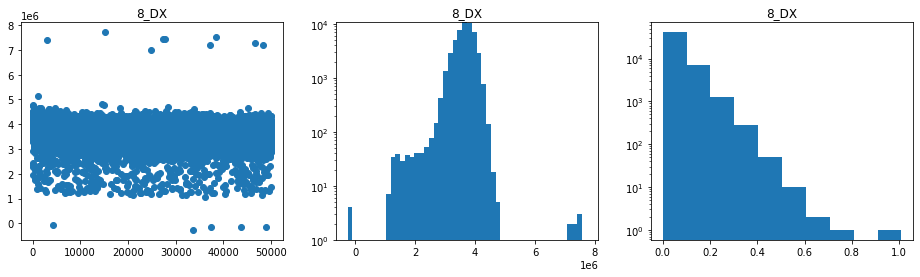

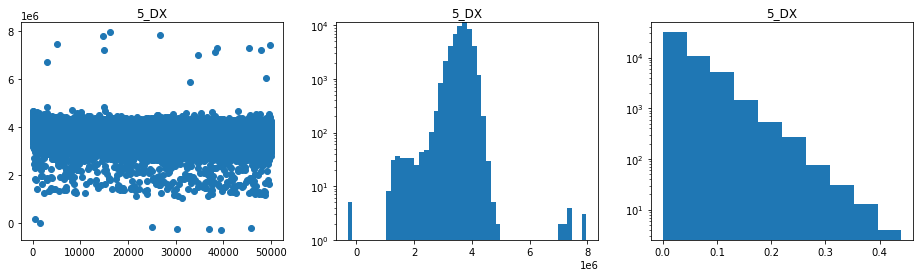

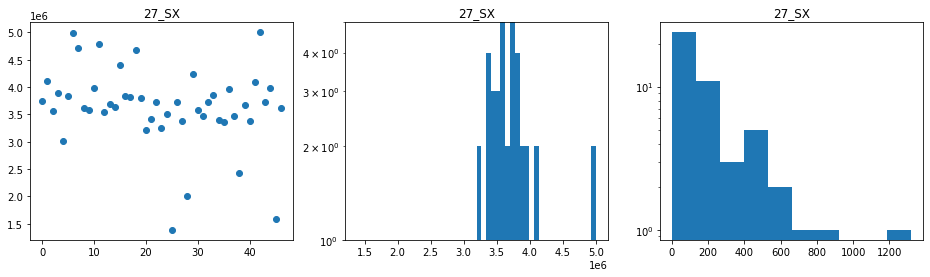

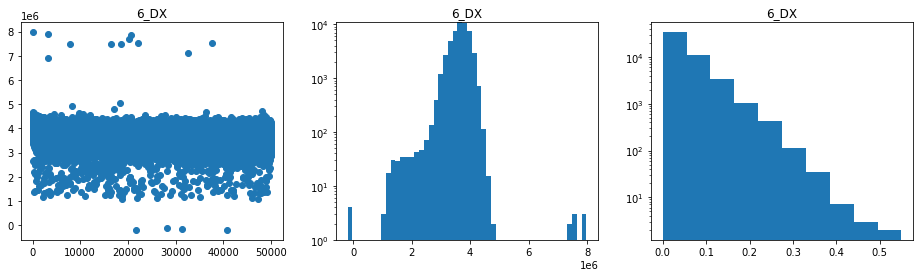

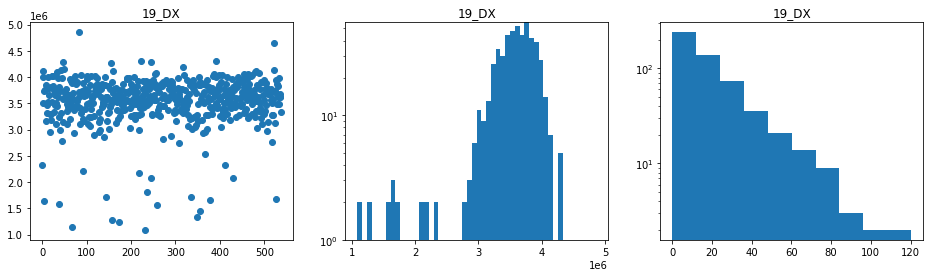

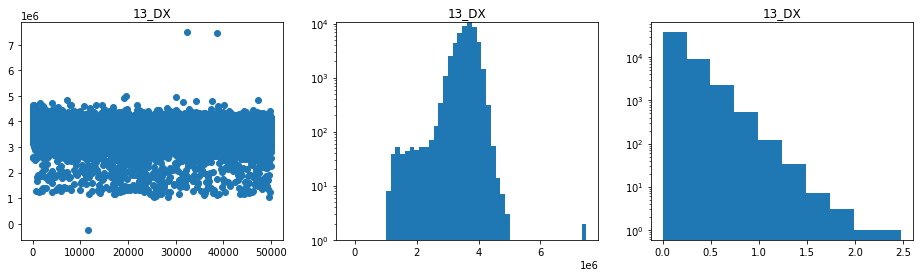

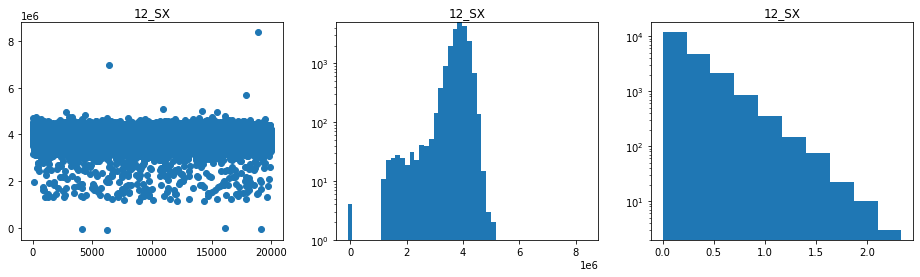

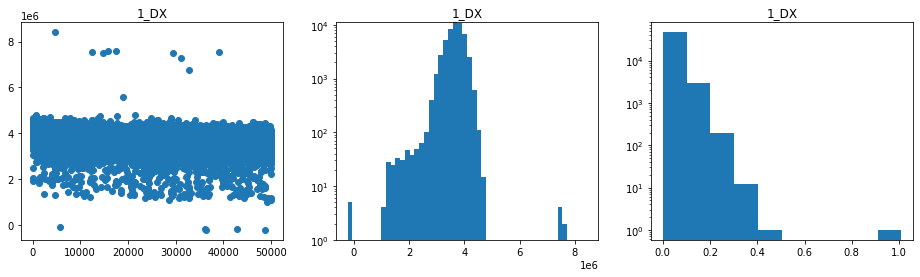

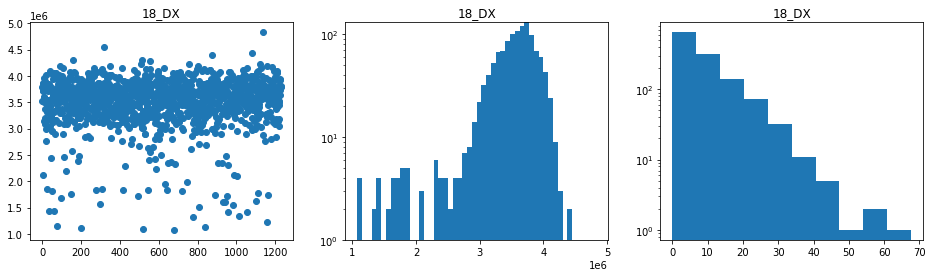

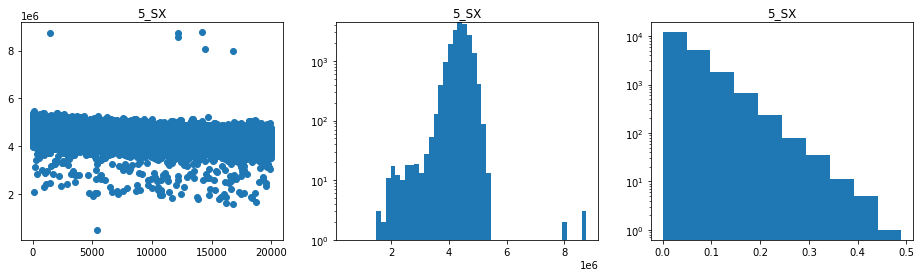

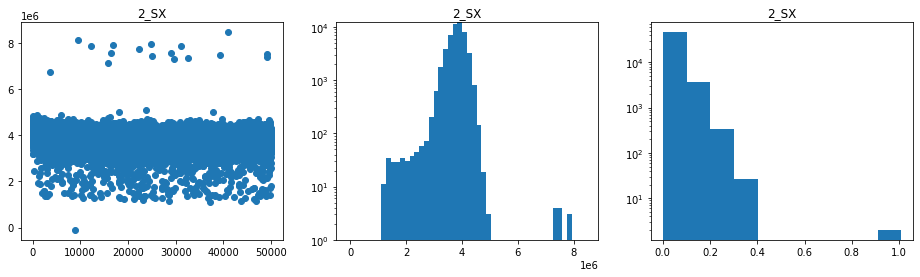

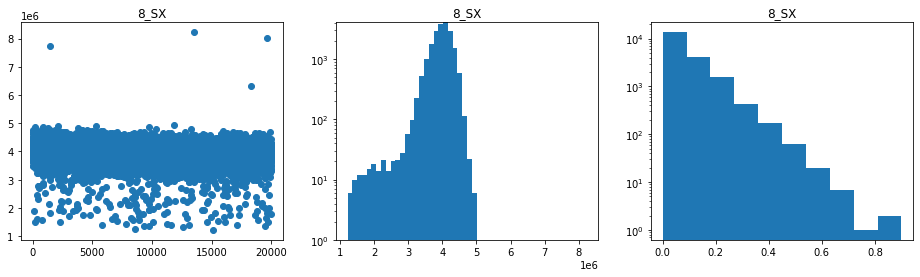

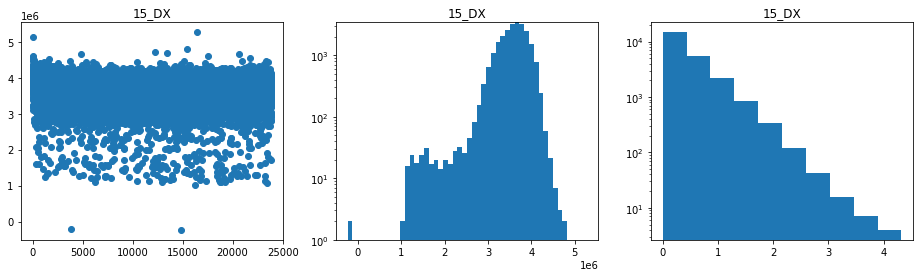

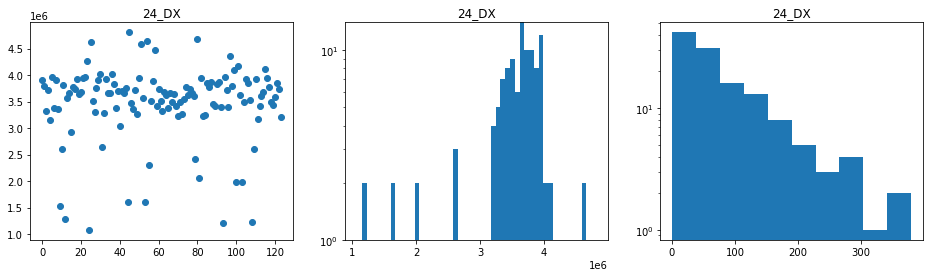

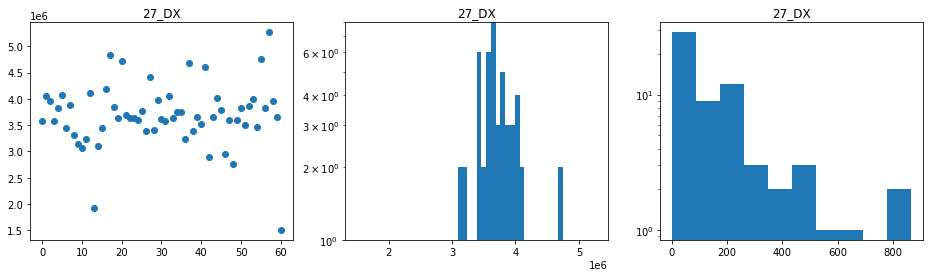

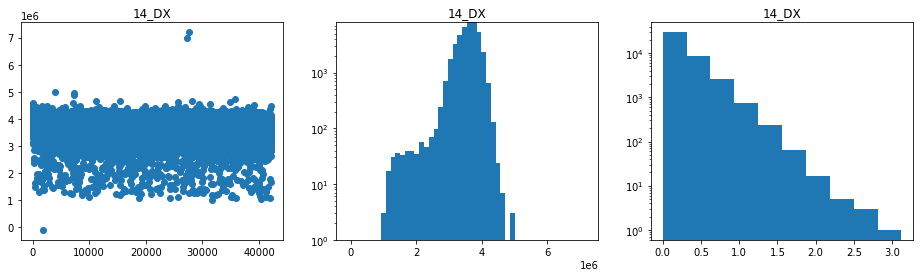

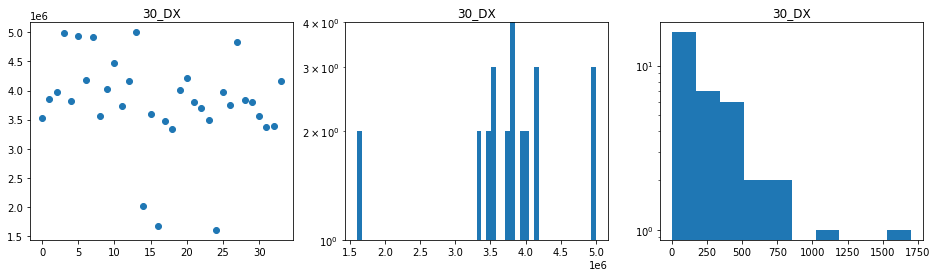

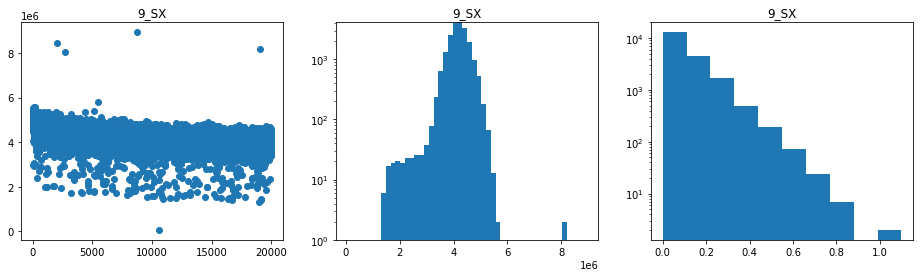

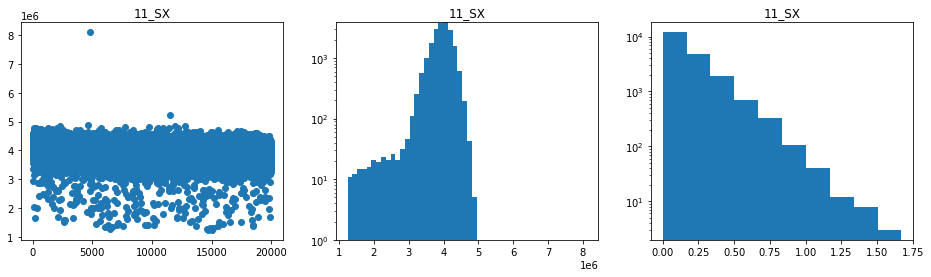

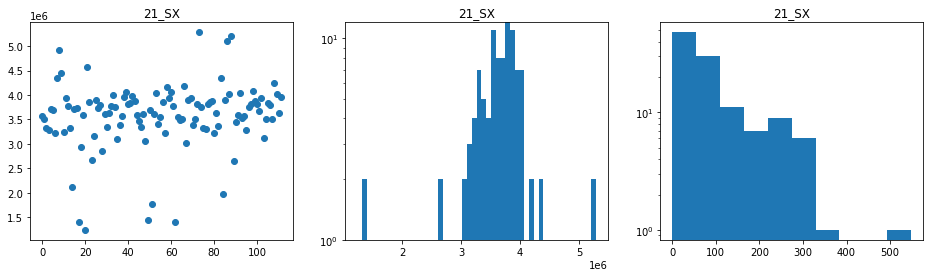

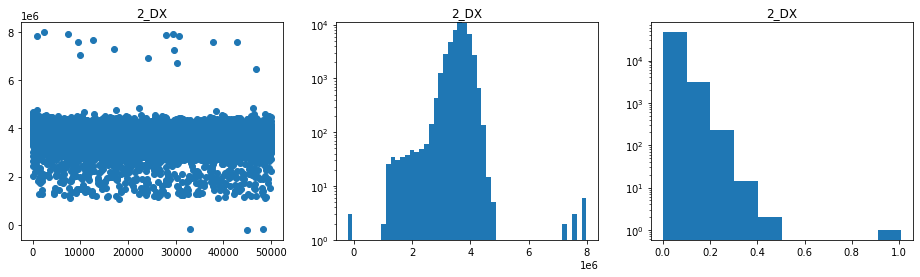

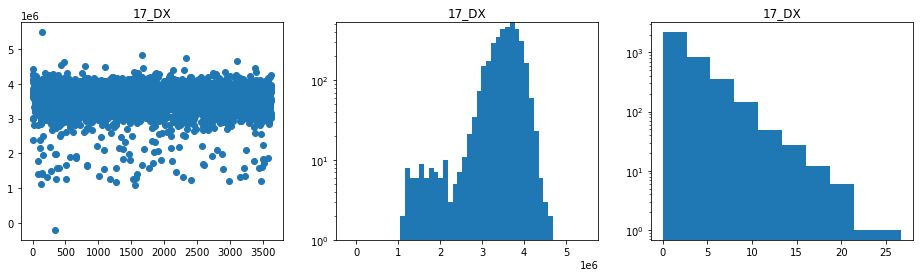

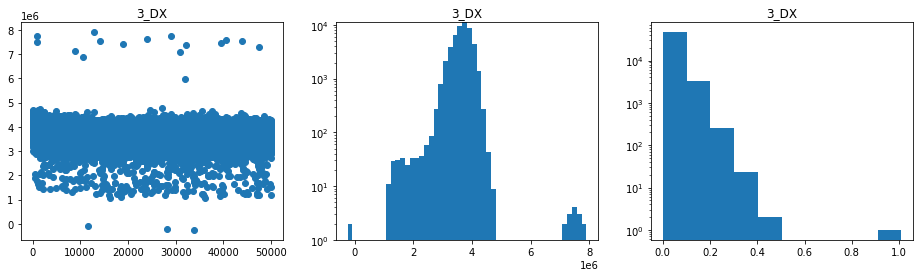

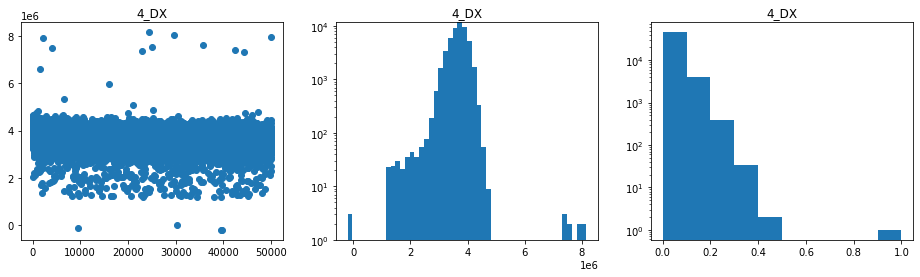

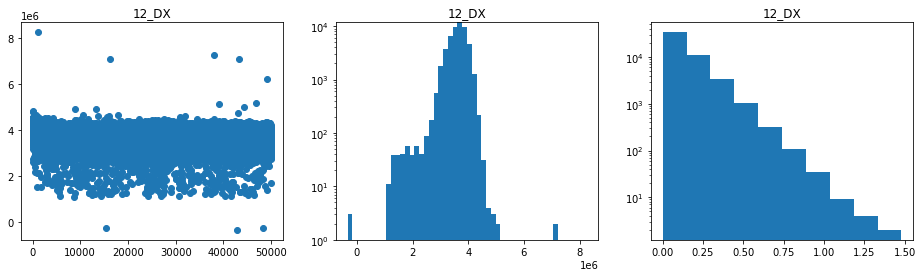

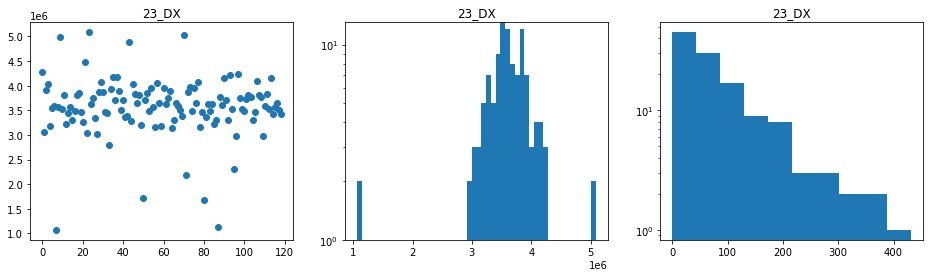

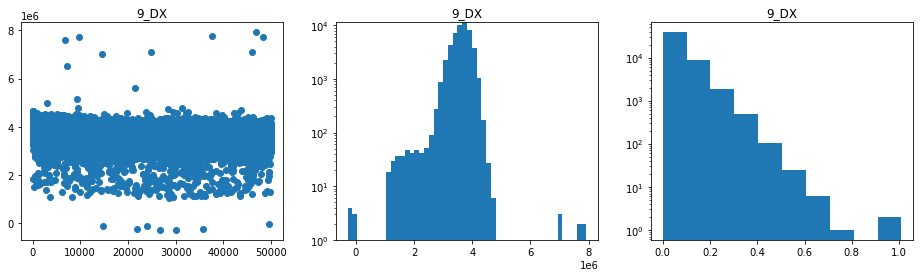

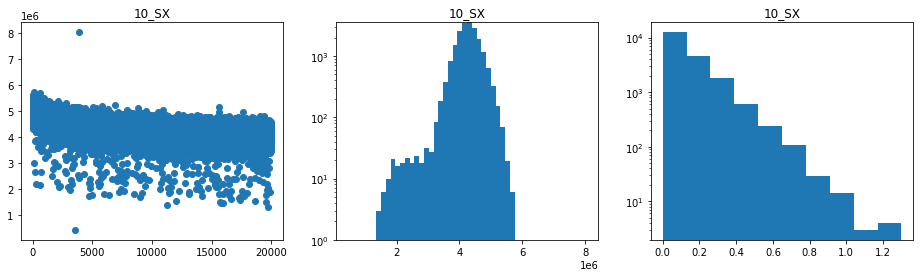

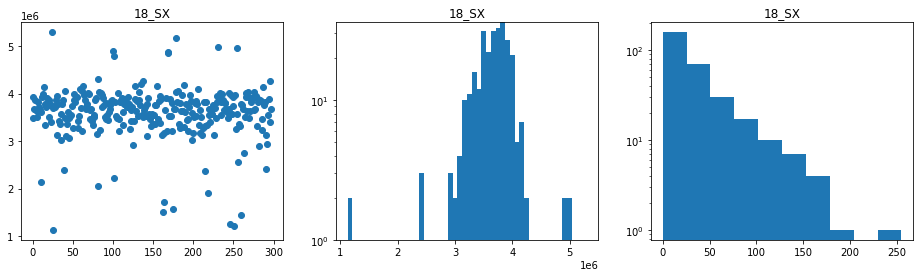

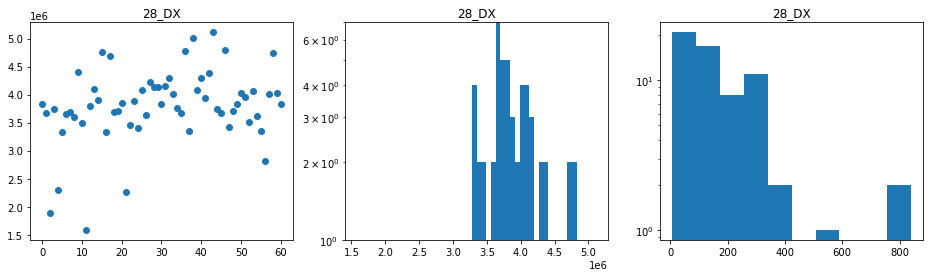

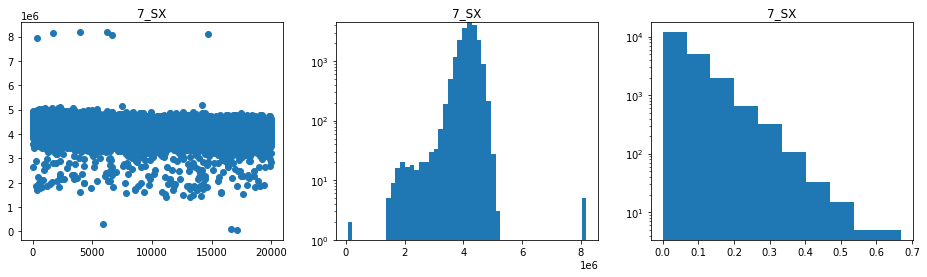

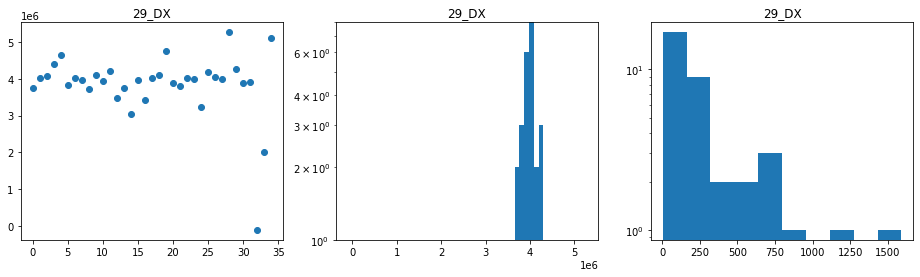

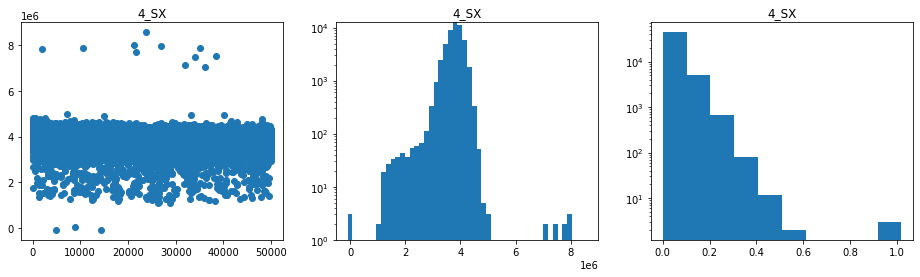

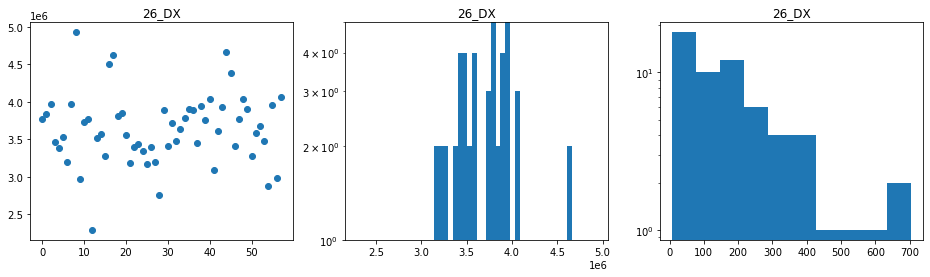

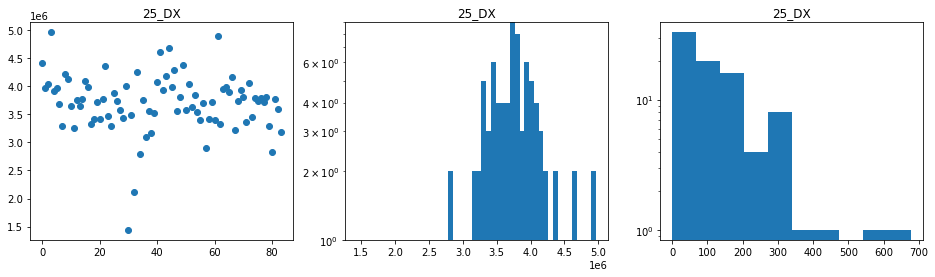

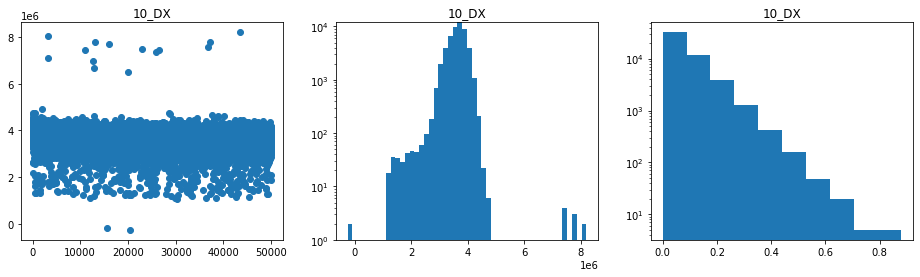

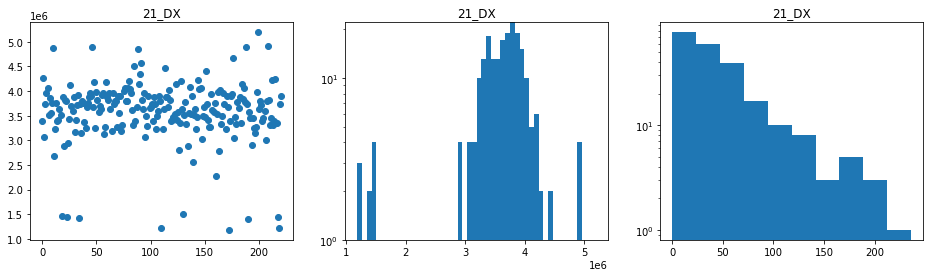

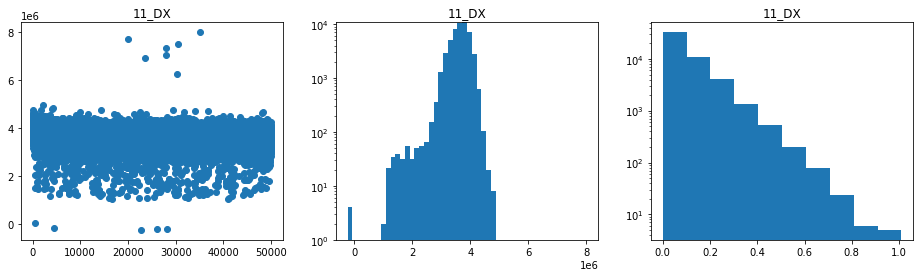

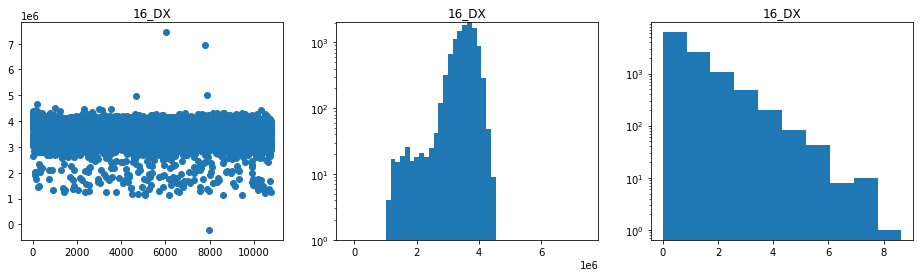

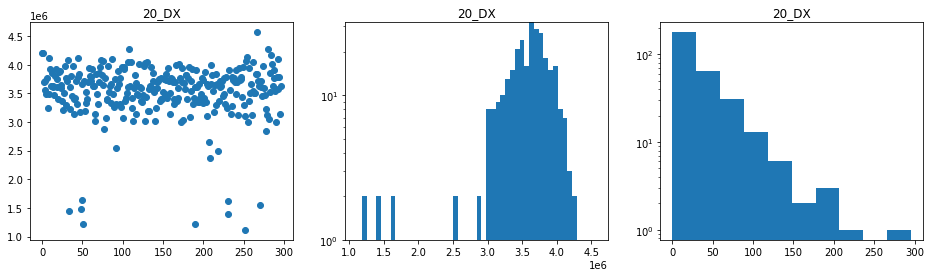

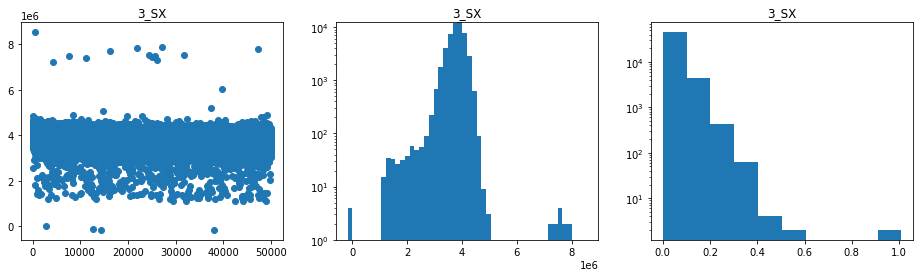

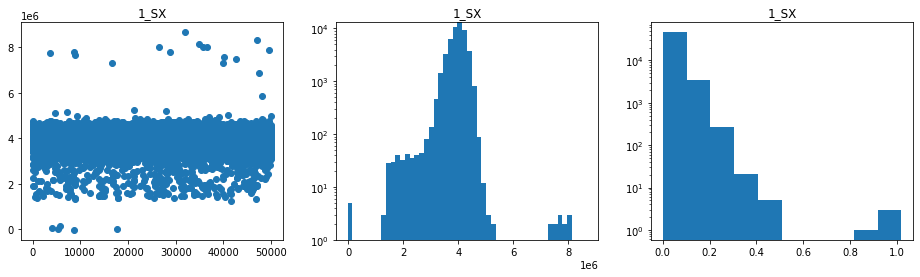

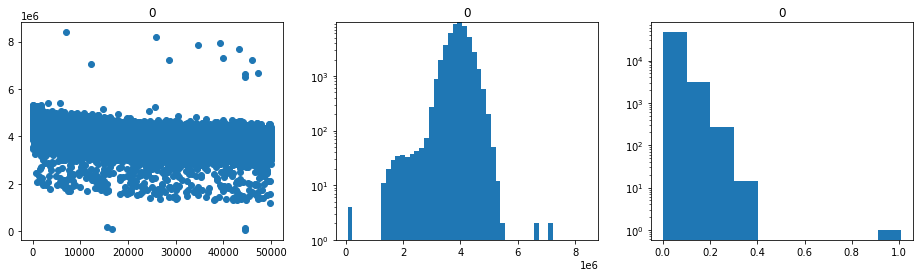

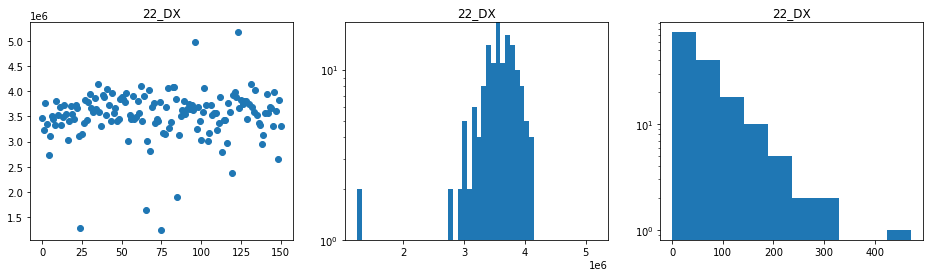

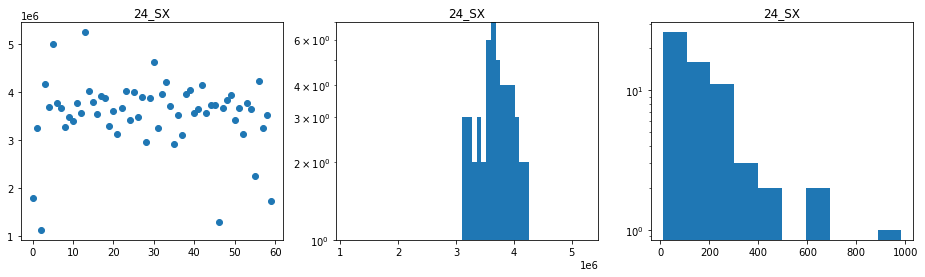

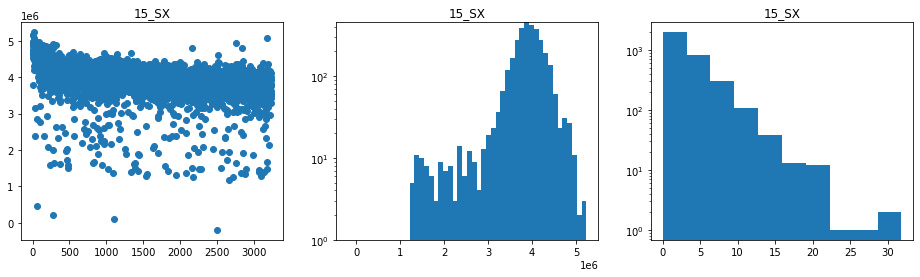

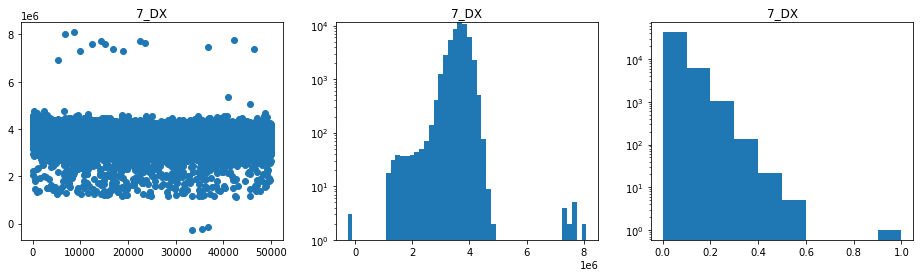

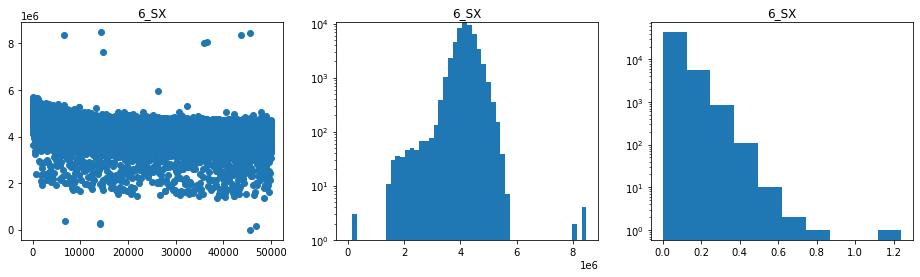

In [21]:
angles   = []
events   = []
times    = []
norms    = []
ev_norms = []

PLOT_DATA = True
FILTER    = False

os.chdir(DATA_PATH)
for d in os.listdir("."):
    os.chdir(d)
    
    if "DX" in d:
        sign = +1
    elif "SX" in d:
        sign = -1
    else:
        sign = 0
    
    angles.append(sign * int(''.join(filter(lambda i: i.isdigit(), d))) * 0.9 * np.pi / 180.0)

    data          = np.load(d+".npy")
    data_int      = np.sum(data, axis=1)
    data_int_mean = np.mean(data_int)
    data_int_var  = np.std(data_int)

    if FILTER:
        mask_t = np.logical_and(data_int<data_int_mean+data_int_var*3, data_int>data_int_mean-data_int_var*3)
        mask_f = np.logical_not(mask_t)
    else:
        mask_t = np.ones(data_int.shape, dtype=np.bool)
        mask_f = np.logical_not(mask_t)
    
    p_s = subprocess.run(["head", "-n 1", "run_BlockTimes.txt"], stdout=subprocess.PIPE)
    p_f = subprocess.run(["tail", "-n 1", "run_BlockTimes.txt"], stdout=subprocess.PIPE)
    t_s = p_s.stdout.decode('utf-8').strip().split('\t')
    t_f = p_f.stdout.decode('utf-8').strip().split('\t')
    
    times.append(float(t_f[1]) - float(t_s[0]))
    events.append(data_int[mask_t].shape[0] / (float(t_f[1]) - float(t_s[0])) * 3600)
    
    t_gap = np.loadtxt("run_BlockTimes.txt")
    norms.append(float(t_f[1]) - float(t_s[0])-np.sum(t_gap[1:,0]-t_gap[:-1,1]))
    #ev_norms.append(data_int[mask_t].shape[0] / (float(t_f[1]) - float(t_s[0])-np.sum(t_gap[1:,0]-t_gap[:-1,1])) * 3600)
    ev_norms.append(data_int[mask_t].shape[0] / np.sum(t_gap[:,1]-t_gap[:,0]) * 3600)

    if PLOT_DATA:
        fig=plt.figure(figsize=(16, 4))
        plt.subplot(1,3,1)
        if mask_f.shape[0] != 0:
            plt.plot(np.where(mask_t)[0], data_int[mask_t], "o")
            plt.plot(np.where(mask_f)[0], data_int[mask_f], "o")
        else:
            plt.plot(np.where(mask_t)[0], data_int[mask_t], "o")
        plt.title(d)

        plt.subplot(1,3,2)
        if mask_f.shape[0] != 0:
            plt.hist([data_int[mask_t], data_int[mask_f]], bins=50, stacked=True)
        else:
            plt.hist(data_int[mask_t], bins=50, stacked=True)
        plt.yscale("log")
        plt.title(d)
        
        plt.subplot(1,3,3)
        plt.hist(t_gap[:,1]-t_gap[:,0])
        plt.yscale("log")
        plt.title(d)
        plt.show()

    os.chdir(DATA_PATH)

### Time gap

In [22]:
os.chdir(DATA_PATH)
os.chdir("0")

p_s = subprocess.run(["head", "-n 1", "run_BlockTimes.txt"], stdout=subprocess.PIPE)
p_f = subprocess.run(["tail", "-n 1", "run_BlockTimes.txt"], stdout=subprocess.PIPE)
t_s = p_s.stdout.decode('utf-8').strip().split('\t')
t_f = p_f.stdout.decode('utf-8').strip().split('\t')
print(t_s)
print(float(t_f[1]) - float(t_s[0]))
#float(res.strip()) for res in results]
#subprocess.call("head run_BlockTimes.txt -n 1", shell=True)
#os.system("head run_BlockTimes.txt -n 1")
os.chdir(DATA_PATH)

['1604071867.7', '1604071867.71']
2354.609999895096


### Events distribution

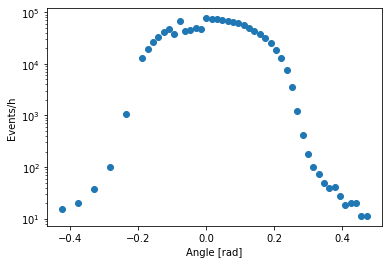

In [26]:
plt.plot(angles, events, "o")
plt.xlabel("Angle [rad]")
plt.ylabel("Events/h")
plt.yscale("log")
plt.show()

In [28]:
print(max(events))
print(max(ev_norms))

76445.78083335223
91351.08331368721


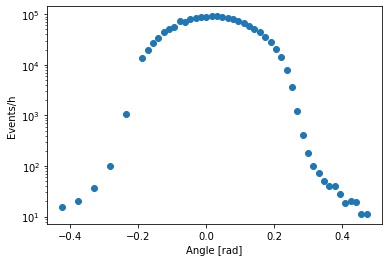

In [25]:
plt.plot(angles, ev_norms, "o")
plt.xlabel("Angle [rad]")
plt.ylabel("Events/h")
plt.yscale("log")
plt.show()